In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.svm import SVC,LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
data = pd.read_csv('train.csv', parse_dates = ['Dates'])
test_df = pd.read_csv('test.csv')

In [3]:
data.head(5)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [4]:
data.shape

(878049, 9)

In [5]:
data.isnull().sum()

Dates         0
Category      0
Descript      0
DayOfWeek     0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
dtype: int64

In [6]:
data['Year'] = data['Dates'].map(lambda x: x.year)
data['Week'] = data['Dates'].map(lambda x: x.week)
data['Hour'] = data['Dates'].map(lambda x: x.hour)

## Data Exploration

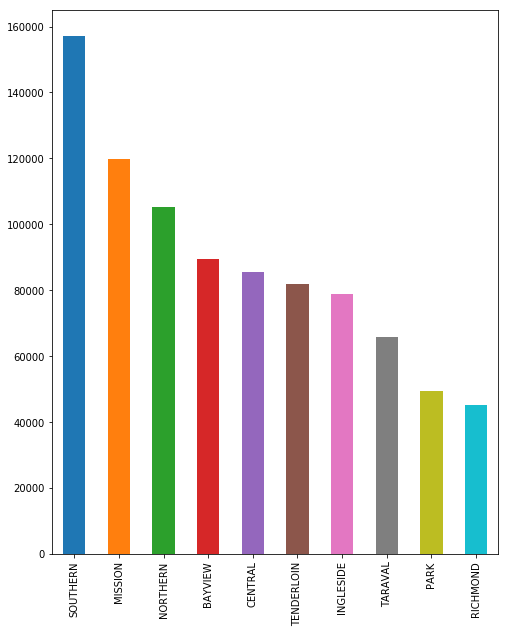

In [7]:
data.PdDistrict.value_counts().plot(kind='bar', figsize=(8,10))

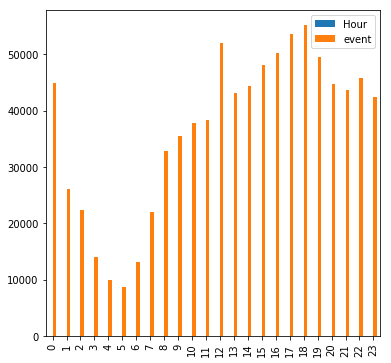

In [8]:
data['event'] = 1
hourly_events = data[['Hour','event']].groupby(['Hour']).count().reset_index()
hourly_events.plot(kind='bar', figsize=(6, 6))

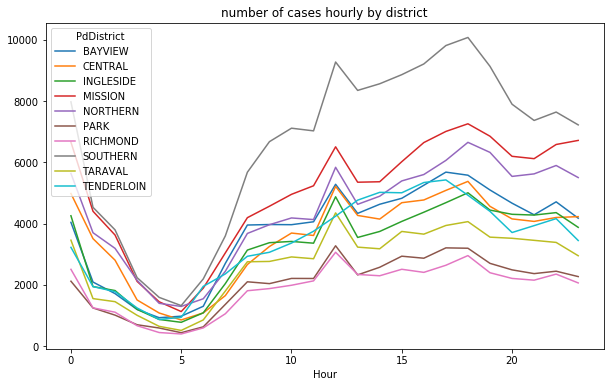

In [9]:
hourly_district_events = data[['PdDistrict','Hour','event']].groupby(['PdDistrict','Hour']).count().reset_index()
hourly_district_events_pivot = hourly_district_events.pivot(index='Hour', columns='PdDistrict', values='event').fillna(method='ffill')
hourly_district_events_pivot.interpolate().plot(title='number of cases hourly by district', figsize=(10,6))

In [10]:
crime_types = data['Category'].unique()
print(crime_types)

['WARRANTS' 'OTHER OFFENSES' 'LARCENY/THEFT' 'VEHICLE THEFT' 'VANDALISM'
 'NON-CRIMINAL' 'ROBBERY' 'ASSAULT' 'WEAPON LAWS' 'BURGLARY'
 'SUSPICIOUS OCC' 'DRUNKENNESS' 'FORGERY/COUNTERFEITING' 'DRUG/NARCOTIC'
 'STOLEN PROPERTY' 'SECONDARY CODES' 'TRESPASS' 'MISSING PERSON' 'FRAUD'
 'KIDNAPPING' 'RUNAWAY' 'DRIVING UNDER THE INFLUENCE'
 'SEX OFFENSES FORCIBLE' 'PROSTITUTION' 'DISORDERLY CONDUCT' 'ARSON'
 'FAMILY OFFENSES' 'LIQUOR LAWS' 'BRIBERY' 'EMBEZZLEMENT' 'SUICIDE'
 'LOITERING' 'SEX OFFENSES NON FORCIBLE' 'EXTORTION' 'GAMBLING'
 'BAD CHECKS' 'TREA' 'RECOVERED VEHICLE' 'PORNOGRAPHY/OBSCENE MAT']


## Feature Engineering

In [11]:
data = pd.read_csv('train.csv')

In [12]:
DayOfWeek_dummies = pd.get_dummies(data['DayOfWeek'])
data = data.join(DayOfWeek_dummies)

In [13]:
PdDistrict_dummies = pd.get_dummies(data['PdDistrict'])
data = data.join(PdDistrict_dummies)

In [14]:
# convert given list of dates it will trim seconds, minutes and return result
def trimMinAndSecFromDates(dates):
    result = []
    for date in dates:
        result.append(date[:-6])
    return result

# trim minutes and seconds from dates
data['Dates'] = trimMinAndSecFromDates(data['Dates'])

# encode Dates using label encoding
data['Dates'] = data['Dates'].astype('category')
data['Dates_int'] = data['Dates'].cat.codes

# encode Address using label encoding
data['Address'] = data['Address'].astype('category')
data['Address_int'] = data['Address'].cat.codes

In [15]:
data.head(10)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Friday,...,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN,Dates_int,Address_int
0,2015-05-13 23,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,0,...,0,0,1,0,0,0,0,0,53629,19790
1,2015-05-13 23,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,0,...,0,0,1,0,0,0,0,0,53629,19790
2,2015-05-13 23,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,0,...,0,0,1,0,0,0,0,0,53629,22697
3,2015-05-13 23,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,0,...,0,0,1,0,0,0,0,0,53629,4266
4,2015-05-13 23,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,0,...,0,0,0,1,0,0,0,0,53629,1843
5,2015-05-13 23,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,Wednesday,INGLESIDE,NONE,0 Block of TEDDY AV,-122.403252,37.713431,0,...,1,0,0,0,0,0,0,0,53629,1505
6,2015-05-13 23,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,INGLESIDE,NONE,AVALON AV / PERU AV,-122.423327,37.725138,0,...,1,0,0,0,0,0,0,0,53629,13322
7,2015-05-13 23,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,BAYVIEW,NONE,KIRKWOOD AV / DONAHUE ST,-122.371274,37.727564,0,...,0,0,0,0,0,0,0,0,53629,18054
8,2015-05-13 23,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,RICHMOND,NONE,600 Block of 47TH AV,-122.508194,37.776601,0,...,0,0,0,0,1,0,0,0,53629,11384
9,2015-05-13 23,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,CENTRAL,NONE,JEFFERSON ST / LEAVENWORTH ST,-122.419088,37.807802,0,...,0,0,0,0,0,0,0,0,53629,17658


In [16]:
columns_train = data.columns
print(columns_train)

Index(['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict',
       'Resolution', 'Address', 'X', 'Y', 'Friday', 'Monday', 'Saturday',
       'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'BAYVIEW', 'CENTRAL',
       'INGLESIDE', 'MISSION', 'NORTHERN', 'PARK', 'RICHMOND', 'SOUTHERN',
       'TARAVAL', 'TENDERLOIN', 'Dates_int', 'Address_int'],
      dtype='object')


## Drop unwanted columns

In [17]:
data = data.drop(["Resolution", "PdDistrict", "Descript", "DayOfWeek", "Address", "Dates"], axis = 1)

In [18]:
data.head(10)

,Category,X,Y,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,...,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN,Dates_int,Address_int
0,WARRANTS,-122.425892,37.774599,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,53629,19790
1,OTHER OFFENSES,-122.425892,37.774599,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,53629,19790
2,OTHER OFFENSES,-122.424363,37.800414,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,53629,22697
3,LARCENY/THEFT,-122.426995,37.800873,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,53629,4266
4,LARCENY/THEFT,-122.438738,37.771541,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,53629,1843
5,LARCENY/THEFT,-122.403252,37.713431,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,53629,1505
6,VEHICLE THEFT,-122.423327,37.725138,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,53629,13322
7,VEHICLE THEFT,-122.371274,37.727564,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,53629,18054
8,LARCENY/THEFT,-122.508194,37.776601,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,53629,11384
9,LARCENY/THEFT,-122.419088,37.807802,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,53629,17658


## Removing redundant rows

In [19]:
lons = data['X'] # longitudes 
lats = data['Y'] # latitudes

print ("Longitudes summary:")
print (lons.describe())
print ("\nLatitudes summary:")
print (lats.describe())

Longitudes summary:
count    878049.000000
mean       -122.422616
std           0.030354
min        -122.513642
25%        -122.432952
50%        -122.416420
75%        -122.406959
max        -120.500000
Name: X, dtype: float64

Latitudes summary:
count    878049.000000
mean         37.771020
std           0.456893
min          37.707879
25%          37.752427
50%          37.775421
75%          37.784369
max          90.000000
Name: Y, dtype: float64


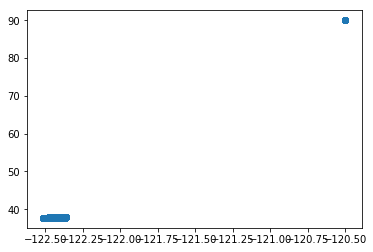

In [20]:
import matplotlib.pyplot as plt


plt.scatter(lons, lats)
plt.show()

In [21]:
data = data.drop(data[(data['Y'] > 37.84) | (data['Y'] < 37.7)].index)
data = data.drop(data[((data['X'] > -122.32) | (data['X'] < -122.52))].index)
data.describe()

,X,Y,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,BAYVIEW,...,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN,Dates_int,Address_int
count,877982.000000,877982.000000,877982.000000,877982.000000,877982.000000,877982.000000,877982.000000,877982.000000,877982.000000,877982.000000,...,877982.000000,877982.000000,877982.000000,877982.000000,877982.000000,877982.000000,877982.000000,877982.000000,877982.000000,877982.000000
mean,-122.422763,37.767035,0.152307,0.138469,0.144427,0.132920,0.142403,0.142320,0.147156,0.101849,...,0.089798,0.136571,0.119916,0.056164,0.051484,0.179017,0.074708,0.093161,26882.653115,9478.254815
std,0.025285,0.024165,0.359319,0.345391,0.351522,0.339488,0.349463,0.349378,0.354261,0.302450,...,0.285892,0.343394,0.324863,0.230238,0.220983,0.383367,0.262919,0.290659,15731.068340,6055.559058
min,-122.513642,37.707879,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-122.432952,37.752427,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13077.000000,4299.000000
50%,-122.416420,37.775421,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26836.000000,9114.000000
75%,-122.406959,37.784368,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40862.000000,12674.000000
max,-122.364937,37.819975,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,53629.000000,23227.000000


In [22]:
data.head(10)

,Category,X,Y,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,...,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN,Dates_int,Address_int
0,WARRANTS,-122.425892,37.774599,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,53629,19790
1,OTHER OFFENSES,-122.425892,37.774599,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,53629,19790
2,OTHER OFFENSES,-122.424363,37.800414,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,53629,22697
3,LARCENY/THEFT,-122.426995,37.800873,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,53629,4266
4,LARCENY/THEFT,-122.438738,37.771541,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,53629,1843
5,LARCENY/THEFT,-122.403252,37.713431,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,53629,1505
6,VEHICLE THEFT,-122.423327,37.725138,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,53629,13322
7,VEHICLE THEFT,-122.371274,37.727564,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,53629,18054
8,LARCENY/THEFT,-122.508194,37.776601,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,53629,11384
9,LARCENY/THEFT,-122.419088,37.807802,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,53629,17658


In [23]:
# encode Dates and Address
test_df['Dates'] = trimMinAndSecFromDates(test_df['Dates'])
test_df['Dates'] = test_df['Dates'].astype('category')
test_df['Dates_int'] = test_df['Dates'].cat.codes
test_df['Address'] = test_df['Address'].astype('category')
test_df['Address_int'] = test_df['Address'].cat.codes
test_df.drop(columns=['Dates', 'Address'], inplace=True)

# encode DayOfWeek and PdDistrict
DayOfWeek_dummies = pd.get_dummies(test_df['DayOfWeek'])
PdDistrict_dummies = pd.get_dummies(test_df['PdDistrict'])
test_df = test_df.join(DayOfWeek_dummies)
test_df = test_df.join(PdDistrict_dummies)
test_df.drop(columns=['DayOfWeek', 'PdDistrict'], inplace=True)

# drop id column
test_df.drop(columns=['Id'], inplace=True)

test_df.head()

,X,Y,Dates_int,Address_int,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,...,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN
0,-122.399588,37.735051,54047,6407,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1,-122.391523,37.732432,54047,9744,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2,-122.426002,37.792212,54047,6336,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,-122.437394,37.721412,54047,10633,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
4,-122.437394,37.721412,54047,10633,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0


## Feature Selection

In [24]:
data.columns

Index(['Category', 'X', 'Y', 'Friday', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday', 'BAYVIEW', 'CENTRAL', 'INGLESIDE',
       'MISSION', 'NORTHERN', 'PARK', 'RICHMOND', 'SOUTHERN', 'TARAVAL',
       'TENDERLOIN', 'Dates_int', 'Address_int'],
      dtype='object')

In [25]:
X = data.drop('Category', axis = 1)
y = data['Category'].copy()

## Modelling

## Random Forest Classifier

In [26]:
RC =RandomForestClassifier(n_estimators = 20, max_features = 21)
RC.fit(X, y)
Y_pred_RC = RC.predict_proba(test_df)

In [27]:
output_rfc = pd.DataFrame(data=Y_pred_RC, columns=RC.classes_)

In [28]:
output_rfc.head(5)

,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0.0,0.250000,0.0,0.0,0.00,0.0,0.0,0.025,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.000000,0.100000,0.30,0.00,0.0
1,0.0,0.158333,0.0,0.0,0.00,0.0,0.0,0.000,0.00,0.0,...,0.0,0.0,0.0,0.05,0.0,0.033333,0.066667,0.20,0.00,0.0
2,0.0,0.150000,0.0,0.0,0.05,0.0,0.0,0.000,0.05,0.0,...,0.0,0.0,0.0,0.05,0.0,0.000000,0.100000,0.25,0.00,0.0
3,0.0,0.200000,0.0,0.0,0.15,0.0,0.0,0.000,0.00,0.0,...,0.0,0.0,0.0,0.05,0.0,0.000000,0.050000,0.15,0.05,0.0
4,0.0,0.200000,0.0,0.0,0.15,0.0,0.0,0.000,0.00,0.0,...,0.0,0.0,0.0,0.05,0.0,0.000000,0.050000,0.15,0.05,0.0


In [29]:
output_rfc.index.name = 'Id'
output_rfc.to_csv("output_rfc.csv")

## AdaBoost Classifier

In [30]:
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 8),
                              n_estimators = 40,
                              learning_rate = 0.5, 
                              random_state = 1)

clf.fit(X, y)
predicted = clf.predict_proba(test_df)

In [31]:
output_ada = pd.DataFrame(data=predicted, columns=clf.classes_)

In [32]:
output_ada.head(5)

,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0.006577,0.108728,0.002461,2.073402e-04,0.050620,0.013145,0.000515,0.095828,0.020756,0.003013,...,2.697141e-06,0.018878,0.001478,0.018229,9.381781e-15,0.027204,0.047508,0.036186,0.097517,0.027270
1,0.001577,0.074343,0.000128,8.113336e-06,0.020989,0.001235,0.000018,0.083700,0.002262,0.004529,...,4.465332e-07,0.002897,0.000276,0.022362,3.606773e-14,0.001942,0.010637,0.011454,0.260856,0.009803
2,0.000123,0.119138,0.000269,5.940287e-07,0.050103,0.019818,0.000163,0.047723,0.003012,0.003167,...,8.719849e-08,0.001128,0.000230,0.039020,1.708557e-14,0.029721,0.096403,0.050536,0.048695,0.001065
3,0.008958,0.093123,0.000013,2.410471e-06,0.034002,0.003557,0.000087,0.058151,0.022547,0.002068,...,1.144123e-07,0.028624,0.001402,0.028367,1.692317e-14,0.017746,0.075514,0.082131,0.087639,0.022241
4,0.008958,0.093123,0.000013,2.410471e-06,0.034002,0.003557,0.000087,0.058151,0.022547,0.002068,...,1.144123e-07,0.028624,0.001402,0.028367,1.692317e-14,0.017746,0.075514,0.082131,0.087639,0.022241


In [33]:
output_ada.index.name = 'Id'
output_ada.to_csv("output_ada.csv")